In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def pOf(mu,nu):
    exp = np.exp(-(mu**2)-((9+4*(mu**2)+8*nu)**2))
    exp2 = (.5)*np.exp(-8*(mu**2)-(8*((nu-2)**2)))
    return (16/(3*np.pi))*(exp+exp2)

In [3]:
def twoParamMCMCNoPT(jump_scale=.1,N=1000,startingPoint=None):
    
    if startingPoint==None:
        mu = [np.random.random()]
        nu = [np.random.random()]
    else:    
        mu = [startingPoint[0]]
        nu = [startingPoint[1]]
    
    likelyhoods = [pOf(mu[0],nu[0])]
    accept = 0
    
    for i in range(0,N):
        newMu = mu[i] + np.random.normal(0,jump_scale)
        newNu = nu[i] + np.random.normal(0,jump_scale)
        oldLikely = likelyhoods[i]
        newLikely = pOf(newMu,newNu)
        h = newLikely/oldLikely
        alpha = np.random.random()
        if h >= alpha:
            mu.append(newMu)
            nu.append(newNu)
            likelyhoods.append(newLikely)
            accept+=1
        else:
            mu.append(mu[i])
            nu.append(nu[i])
            likelyhoods.append(oldLikely)
        
    return mu, nu, likelyhoods, 100*(accept/N)

In [4]:
jump_scale = .1
N = 100000
burn = int(.25*N)
hist_bins = 100
start = [0,-1]

muChain, nuChain, likelyhoods, acceptance = twoParamMCMCNoPT(jump_scale,N,startingPoint=start)

Accepted: 61.785999999999994%


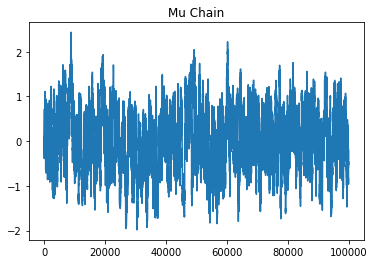

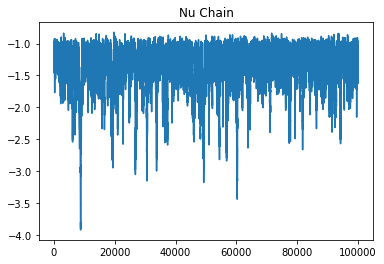

Histograms:


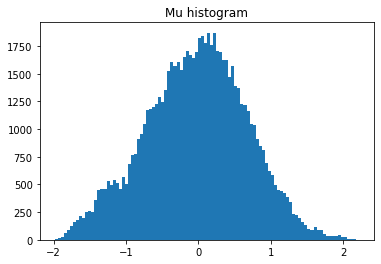

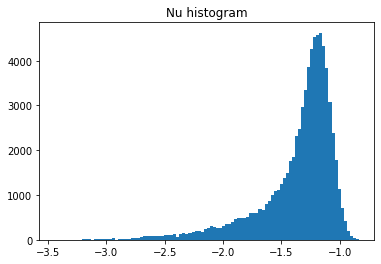

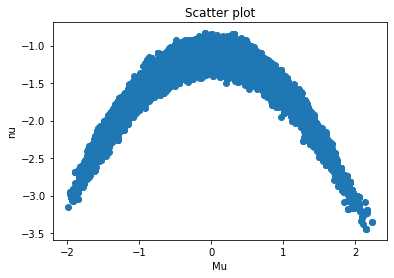

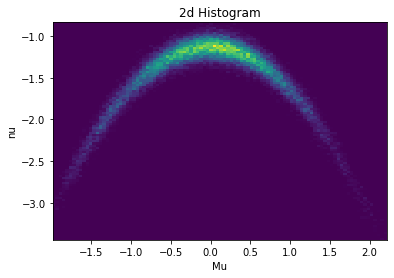

In [5]:
print("Accepted: "+ str(acceptance)+"%")
plt.plot(muChain)
plt.title("Mu Chain")
plt.show()
plt.plot(nuChain)
plt.title('Nu Chain')
plt.show()
'''
#Doesn't show much that is useful
plt.plot(likelyhoods)
plt.title("Likelyhoods")
plt.show()
'''
print("Histograms:")
plt.hist(muChain[burn:],bins=hist_bins)
plt.title('Mu histogram')
plt.show()
plt.hist(nuChain[burn:],bins=hist_bins)
plt.title('Nu histogram')
plt.show()
plt.scatter(muChain[burn:],nuChain[burn:])
plt.title('Scatter plot')
plt.xlabel('Mu')
plt.ylabel('nu')
plt.show()
plt.hist2d(muChain[burn:],nuChain[burn:],density=True,bins=100)
plt.title('2d Histogram')
plt.xlabel('Mu')
plt.ylabel('nu')
plt.show()

In [6]:
jump_scale = .1
N = 100000
burn = int(.25*N)
hist_bins = 100
start = [0,1]

muChain, nuChain, likelyhoods, acceptance = twoParamMCMCNoPT(jump_scale,N,startingPoint=start)

Accepted: 80.46%


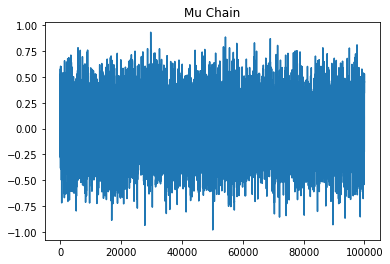

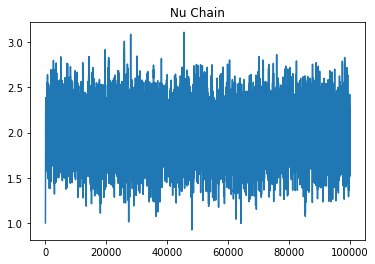

Histograms:


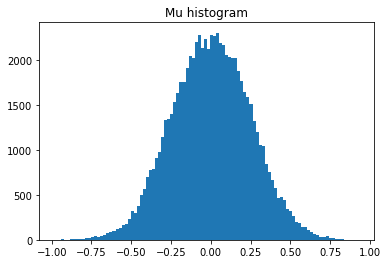

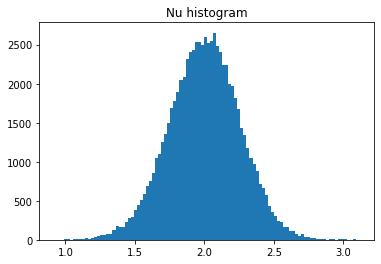

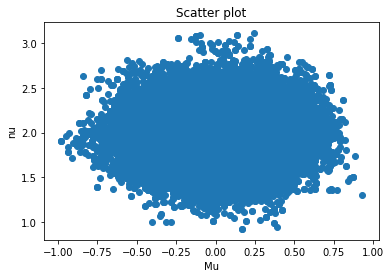

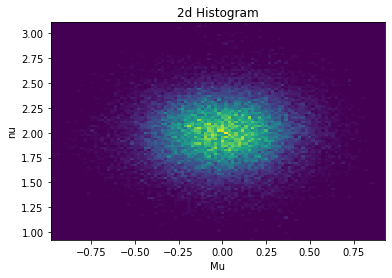

In [7]:
print("Accepted: "+ str(acceptance)+"%")
plt.plot(muChain)
plt.title("Mu Chain")
plt.show()
plt.plot(nuChain)
plt.title('Nu Chain')
plt.show()
'''
#Doesn't show much that is useful
plt.plot(likelyhoods)
plt.title("Likelyhoods")
plt.show()
'''
print("Histograms:")
plt.hist(muChain[burn:],bins=hist_bins)
plt.title('Mu histogram')
plt.show()
plt.hist(nuChain[burn:],bins=hist_bins)
plt.title('Nu histogram')
plt.show()
plt.scatter(muChain[burn:],nuChain[burn:])
plt.title('Scatter plot')
plt.xlabel('Mu')
plt.ylabel('nu')
plt.show()
plt.hist2d(muChain[burn:],nuChain[burn:],density=True,bins=100)
plt.title('2d Histogram')
plt.xlabel('Mu')
plt.ylabel('nu')
plt.show()

In [346]:
def twoParamMCMCWithPT(jump_scale=.1,chains=4,N=1000):
    #Setting the tempuratures for chains
    T = np.zeros(chains)
    T[0] = 1
    if chains == 2:
        T[1] = 1.5
    elif chains >= 3:
        T[1] = 1.5
        for i in range(2,chains):
            T[i]=T[i-1]**1.5
    
    #Chosing zeros for all starting values and initiallizing arrays
    mu = np.zeros((N+1,chains))
    nu = np.zeros((N+1,chains))
    
    #Separate acceptance ratings for each chain
    accept = np.zeros(chains)
    swapcount = 0
    
    for i in range(0,N): #For each iteration of all chains
        for j in range(0,chains): #For each chain
            newMu = mu[i][j] + np.random.normal(0,jump_scale)
            newNu = nu[i][j] + np.random.normal(0,jump_scale)
            oldLikely = pOf(mu[i][j],nu[i][j])**(1/T[j])
            newLikely = (pOf(newMu,newNu))**(1/T[j])
            h = newLikely/oldLikely
            alpha = np.random.random()
            if h >= alpha:
                mu[i+1][j] = newMu
                nu[i+1][j] = newNu
                accept[j]+=1
            else:
                mu[i+1][j] = mu[i][j]
                nu[i+1][j] = nu[i][j]
        
        #End of for j loop
        if i%8==0 and i!=0:
            #print('before: mu:{}, nu:{}'.format(mu[i],nu[i]))
            swaps, mu, nu = swapProposal(i,mu,nu,T)
            swapcount+=swaps
            #if(swaps>=1):
            #    print('after: mu:{}, nu:{}'.format(mu[i],nu[i]))
            
    #End of for i loop
    return mu, nu, (accept/N)*100, swapcount


def swapProposal(i,mu,nu,T):
    swaps = 0
    for j in range(0,len(T)-1):
        swapTop = (pOf(mu[i][j+1],nu[i][j+1])**(1/T[j]))*(pOf(mu[i][j],nu[i][j])**(1/T[j+1]))
        swapBottom = (pOf(mu[i][j+1],nu[i][j+1])**(1/T[j+1]))*(pOf(mu[i][j],nu[i][j])**(1/T[j]))
        swapH = swapTop/swapBottom 
        #swapH = ((pOf(mu[i][j+1],nu[i][j+1])**(1/T[j])) * (pOf(mu[i][j],nu[i][j])**(1/T[j+1])))/((pOf(mu[i][j],nu[i][j])**(1/T[j])) * (pOf(mu[i][j+1],nu[i][j+1])**(1/T[j+1])))
    
        if swapH >= np.random.random():
            muTemp = mu[i][j]
            nuTemp = nu[i][j]
        
            mu[i][j] = mu[i][j+1]
            nu[i][j] = nu[i][j+1]
        
            mu[i][j+1] = muTemp
            nu[i][j+1] = nuTemp
            
            swaps +=1
        
        
    return swaps, mu, nu

'''
def swapProposal(index,mu,nu,T):
    #import pdb; pdb.set_trace()
    i = index-1   #Index of last data
    j = np.random.randint(0,len(T)-1) #index of current chain to test against j+1
    #mu[i][j] gives the mu value for iteration i with chain j
    
    swapTop = (pOf(mu[i][j+1],nu[i][j+1])**(1/T[j]))*(pOf(mu[i][j],nu[i][j])**(1/T[j+1]))
    swapBottom = (pOf(mu[i][j+1],nu[i][j+1])**(1/T[j+1]))*(pOf(mu[i][j],nu[i][j])**(1/T[j]))
    swapH = swapTop/swapBottom 
    alpha = np.random.random()
    if swapH>=alpha:
        mu[i+1][j] = mu[i][j+1]
        nu[i+1][j] = nu[i][j+1]
        
        mu[i+1][j+1] = mu[i][j]
        nu[i+1][j+1] = nu[i][j]
        
        for k in range(0,len(T)):
            if k != j and k != j+1:
                mu[i+1][k] = mu[i][k]
                nu[i+1][k] = nu[i][k]
        
        return 1
    else:
        for k in range(0,len(T)):
            mu[i+1][k] = mu[i][k]
            nu[i+1][k] = nu[i][k]
        return 0
'''
print('Good')

Good


In [205]:
def showChain(i):
    print("Accepted: "+ str(acceptances[i])+"%")
    plt.plot(muChains[i])
    plt.title("Mu Chain")
    plt.show()
    plt.plot(nuChains[i])
    plt.title('Nu Chain')
    plt.show()
    print("Histograms:")
    plt.hist(muChains[i][burn:],bins=hist_bins)
    plt.title('Mu histogram')
    plt.show()
    plt.hist(nuChains[i][burn:],bins=hist_bins)
    plt.title('Nu histogram')
    plt.show()
    plt.scatter(muChains[i][burn:],nuChains[i][burn:])
    plt.title('Scatter plot')
    plt.xlabel('Mu')
    plt.ylabel('nu')
    plt.show()
    plt.hist2d(muChains[i][burn:],nuChains[i][burn:],density=True,bins=100)
    plt.title('2d Histogram')
    plt.xlabel('Mu')
    plt.ylabel('nu')
    plt.show()

In [347]:
jump_scale = .25
N = 100000
burn = int(.25*N)
hist_bins = 100


chains = 9

muChains, nuChains, acceptances, swapcount = twoParamMCMCWithPT(jump_scale,chains,N)

muChains = np.swapaxes(muChains,0,1)
nuChains = np.swapaxes(nuChains,0,1)
print(swapcount)

66847


Accepted: 69.72500000000001%


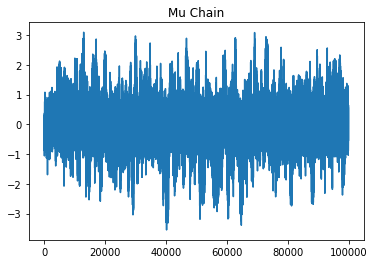

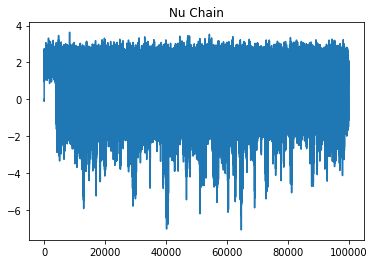

Histograms:


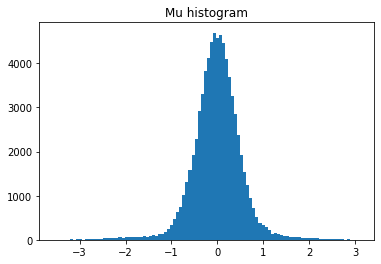

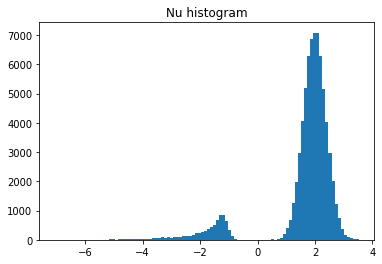

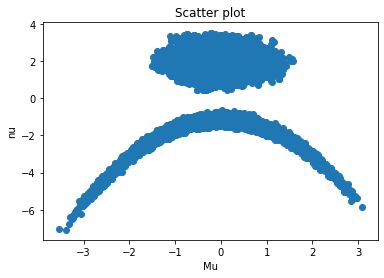

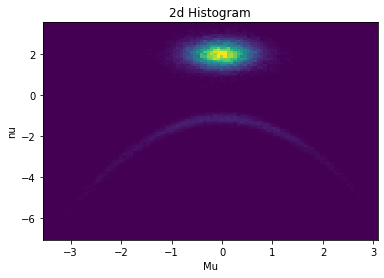

In [352]:
showChain(3)